## Simulations of developing malaria immunity
This notebook attempts to recapitulate the stochastic modelling of blood stage acquired immunity described 
in [Pinkevych et al](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002729#s2).

This is my first time creating a model, so please bear with me. I will try
comment this baby up.

In [2]:
from scipy.stats import expon
import scipy.stats as st
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#import altair as alt
import pandas as pd
#from autograd import jacobian
import time
import math
from sympy import symbols, diff

#### Parameters

In [3]:
N = 10 # number of individuals to simulate
n = 50 # number of strains
l = 0.00000006 # general immunity acquisition rate
r = 16 # starting parasite multipication rate
delta = 0.005 # general immunity loss rate
alpha = 0.000015 # strain specific immunity acquisition rate
beta = 0.003 # strain specific immunity loss rate
k = 0.11 # average number of bites per day
epsilon = 0.056 # initial number of infected RBCs, in millions
Z = 0.005 # Parasite gone threshhold
y = 5 # years to simulate


#### Step 1: Simulate bites.

In [4]:
def simulate_bites(y,k,N,n):
    '''
    Produces N x b x 2 matrix with time between bites
    in M[:,:,0] & strain_choice in M[:,:,1].
    
    Time between bites pulled from exponential distribution with mean rate of k.
    Strains pulled from a uniform distribution.
    '''
    b = round(y*k*365*1.5)
    M = np.empty((N,b,2))
    strains = np.arange(n)
    for i in np.arange(N):
        biting_times = expon.rvs(scale=(1/k), loc=0, size=b)
        strain_choice = np.random.choice(strains,b)
        M[i,:,0] = biting_times
        M[i,:,1] = strain_choice
    return M

#### Step 2: Define equations

In [5]:
def volume(x):
    '''
    Returns blood volume at age x in days.
    '''
    if x < (22*365):
        return (0.00059*x + 0.3)
    else:
        return 5

In [6]:
def h(x,Z=0.005):
    '''
    Returns parasitemia below threshold as 1.
    '''
    if x < Z:
        return 1
    else:
        return 0

In [7]:
def drop(x,Z=0.005):
    '''
    Returns parasitemia below threshold as zero.
    Otherwise returns parasitemia
    '''
    if x < Z:
        return 0
    else:
        return x

In [8]:
def dP(x,y,z,r=16,K=1000000):
    '''
    dP/dT per strain
    '''
    value = 1-h(x)
    return (value*(np.log(r)/2) - z - y)*x*(1-(x/K))

In [9]:
def dS(x,y,alpha=0.05,beta=0.003): #alpha=0.000015, alpha=0.05 for binary
    '''
    dS/dT per strain
    '''
    #return (alpha*x) - (beta*h(x)*y)
    return ((1-h(x))*alpha) - (beta*h(x)*y)
    #if x == 0:
        #print("yeehah")
    #    return (alpha*x) - (beta*h(x)*y)
    #else:
    #print(x)
    #x = drop(x)
    #dawg =  x + 1
    #if dawg < 1:
    #    print(x)
    #    print(dawg)
    #    print('-----')
    #return (alpha*(math.log10(dawg))) - (beta*h(x)*y)

In [33]:
def equations(t,state,n,l=0.001,delta=0.005): #l=0.00000006, l = 0.001 for binary
    '''
    Returns ODEs to integrate
    '''
    p = np.vectorize(drop, excluded=['Z'])(state[0:n], 0)
    s = state[n:(2*n)]
    G = state[-1]
    dY = np.empty((2*n)+1)
    dY[0:n] = np.vectorize(dP)(p,s,G)
    dY[n:(2*n)] = np.vectorize(dS)(p,s)
    #dY[-1] = (l*np.sum(p)) - (delta*h(np.sum(p))*G)
    dY[-1] = (l*(1-h(np.sum(p)))) - (delta*h(np.sum(p))*G)
    #totalP = np.sum(p)
    #print(totalP)
    #if totalP==0:
        #print("dope")
    #    (l*totalP) - (delta*h(np.sum(p))*G)
    #else:
    #dY[-1] = (l*(math.log10(totalP + 1))) - (delta*h(totalP)*G)
    return dY

In [34]:
def jac_sparse(n):
    '''
    Returns Jacobian matrix to speed up calculations.
    '''
    M = np.zeros((2*n+1,2*n+1), dtype=int)
    for strain in np.arange(n):
        M[strain, strain] = 1
        M[strain, (strain + n)] = 1
        M[strain,-1] = 1
        M[(strain+n),strain] = 1
        M[(strain+n),(strain+n)] = 1
        M[-1,strain] = 1
        M[-1,-1] = 1
    return M

In [35]:
jac_sparse(50)

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 0, 1]])

In [36]:
#def wrapper_equations(t, y):
 #   equations(t,y,n)

#### Step 3: Solve & update equations.

In [37]:
def get_bite_times(M,p,years):
    '''
    Returns bite times for 0 to y years from times between bites
    for person p.    
    '''
    tUpdate = []
    time = 0
    for t in np.arange(M.shape[1]):
        time += M[p,t,0]
        if time > (years*365):
            break
        tUpdate.append(time)
    tUpdate.append(years*365)
    return tUpdate

In [38]:
def get_bite_strains(M,p):
    '''
    Returns strains associated with each bite for person p.
    '''
    strains = M[p,:,1]
    return strains.astype(int)

In [39]:
def simulate_person(years, n, tBites, bStrains,epsilon=0.056):
    '''
    Simulates infection per person.
    Returns strain specific parasitemia, immunity, 
    & general immunity for y * 365 days in 2n+1 x days matrix.
    '''
    total_days = years*365
    results = np.empty((2*n+1,total_days))
    current_time = 0
    sparsity = jac_sparse(n)

    for i, day in enumerate(tBites):
        # first interval starts at zero
        if i == 0:
            y0 = np.zeros(2*n+1)
            t0 = 0
            
        record = np.arange(np.ceil(t0),np.ceil(day))
        length = len(record)
        times = np.append(record,day)
        output = solve_ivp(fun=lambda t, y: equations(t, y, n), t_span=(t0,day), y0=y0, t_eval=times, jac_sparsity=sparsity, method='BDF')
        if output.success == False:
            print(output.message)
            raise ValueError('overflow--adjust numbers')
            break
        results[:,current_time:(current_time+length)] = output.y[:,:-1]
        
        if day < total_days:
            end_value = output.y[:,-1]
            t0 = output.t[-1]
            current_time += length

            # Check that strain parasitemia isn't below threshold
            y0 = np.vectorize(drop, otypes=['float'])(end_value)

            # inoculate with strain
            strain = bStrains[i]
            y0[strain] += (epsilon/volume(day))
        
    return results

In [40]:
def simulate_cohort(y,k,N,n):
    '''
    Simulates infections for all people.
    Returns N x 2n+1 x y*365 matrix.
    '''
    M = simulate_bites(y,k,N,n)
    simulations = np.empty((N,2*n+1,y*365))
    
    for p in range(N):
        biteTimes = get_bite_times(M,p,y)
        biteStrains = get_bite_strains(M,p)
        simulations[p,:,:] = simulate_person(y,n,biteTimes,biteStrains)
        
    return simulations
        
        

In [41]:
#start = time.time()
simulations = simulate_cohort(5,0.02,10,50)
#bite_rate = 0.02 is realistic
#end = time.time()
#print(end-start)

#### Step 4: Plot simulations

In [19]:
total_parasitemia = np.sum(simulations[:,0:n,:], axis=1)
average_parasitemia = np.average(total_parasitemia, axis=0)
average_immunity = np.average(simulations[:,-1,:], axis=0)
general_immunity = simulations[:,-1,:]


In [20]:
def calc_ci(y,p):
    lows = []
    highs = []
    for i in np.arange(365*y):
        a = p[:,i]
        low, high = st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
        lows.append(low)
        highs.append(high)
    return np.asarray(lows), np.asarray(highs)

low_p, high_p = calc_ci(5, total_parasitemia)
low_G, high_G = calc_ci(5, general_immunity)

/Users/cwagner2/opt/miniconda3/envs/antigens/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/cwagner2/opt/miniconda3/envs/antigens/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


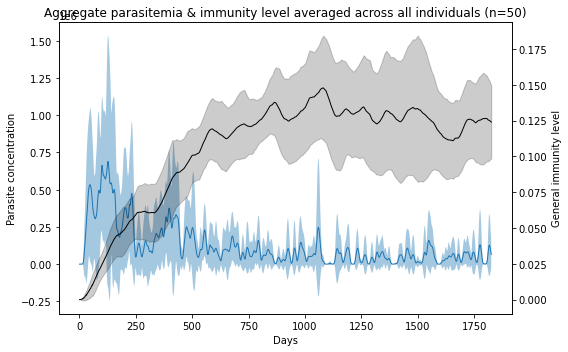

In [21]:
time = np.arange(1,1826)
plt.rcParams.update({'figure.max_open_warning': 0})

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(time,average_parasitemia, lw=1)
ax1.fill_between(time, low_p, high_p, alpha=0.4)
ax2 = ax1.twinx()
ax2.plot(time, average_immunity, color='black', lw=1)
ax2.fill_between(time, low_G, high_G, color='black', alpha=0.2)
ax1.set_xlabel('Days')
ax1.set_ylabel('Parasite concentration')
ax2.set_ylabel('General immunity level')
ax1.set_title('Aggregate parasitemia & immunity level averaged across all individuals (n=50)')
fig.tight_layout()
#fig.savefig('figures/averageInfection_reducedImmuneWaning.png')

In [22]:
plt.rcParams.update({'figure.max_open_warning': 0})


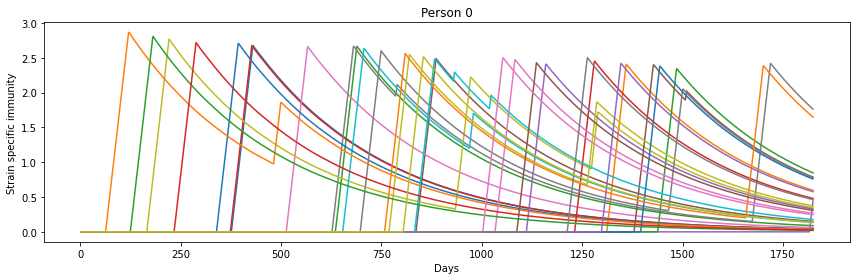

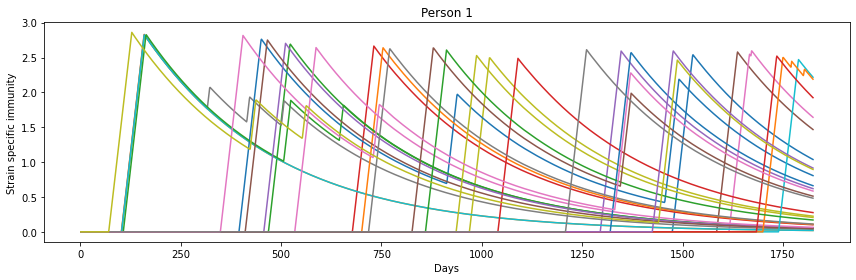

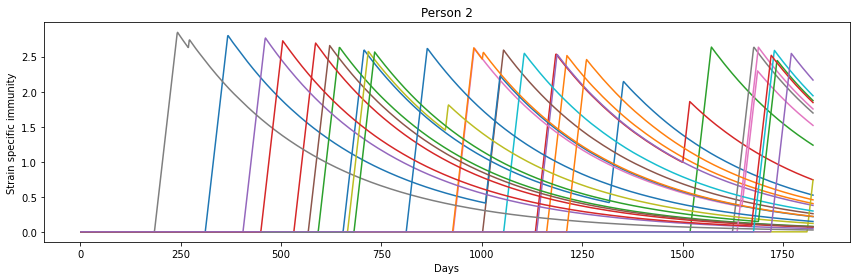

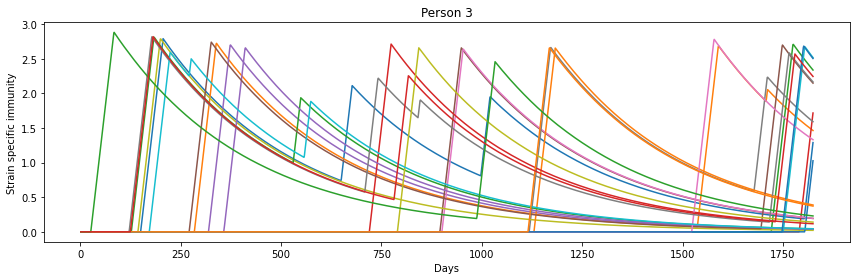

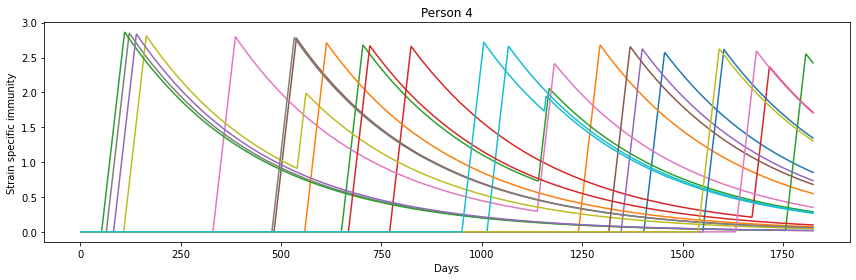

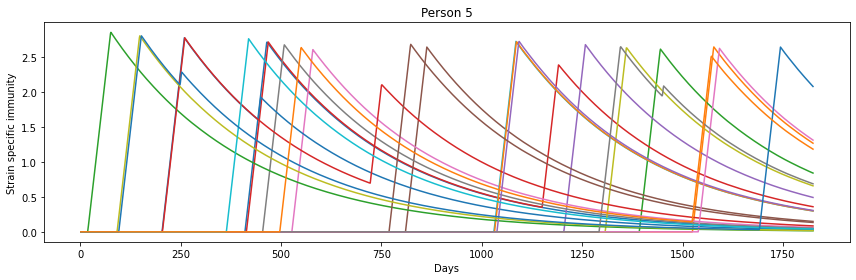

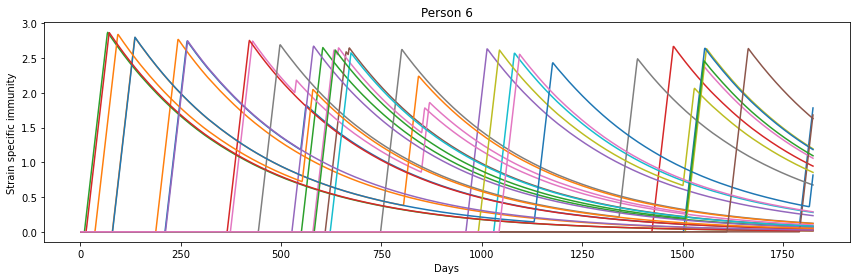

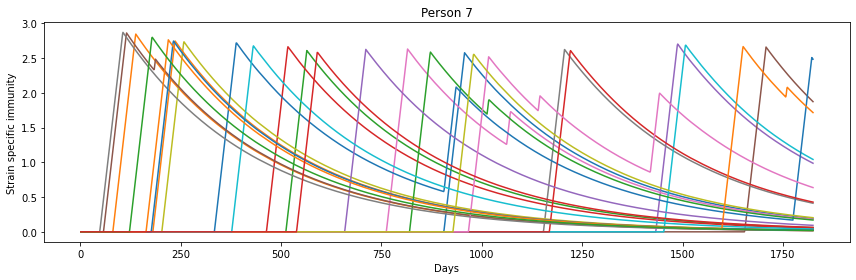

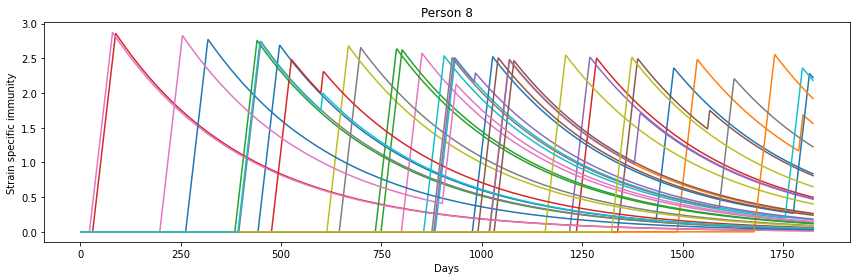

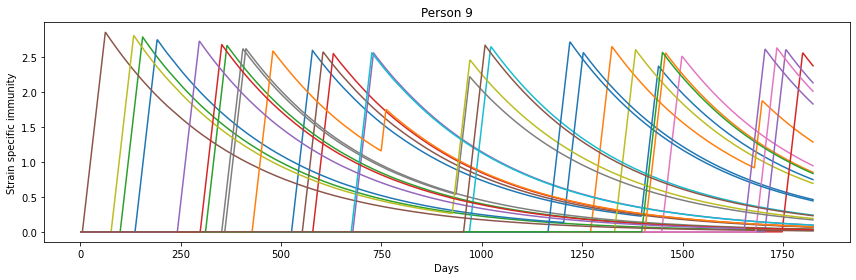

In [23]:
for i in np.arange(N):
    fig, ax = plt.subplots(figsize=(12,4))
    for strain in np.arange(n):
        iStrain = simulations[i,strain+n,:]
        if np.sum(iStrain) > 1:
            ax.plot(time, iStrain)
    ax.set_xlabel('Days')
    ax.set_ylabel('Strain specific immunity')
    ax.set_title('Person ' + str(i))
    fig.tight_layout()
    #fig.savefig('figures/person'+str(i)+'_strainImmunity_reducedImmuneWaning.png')

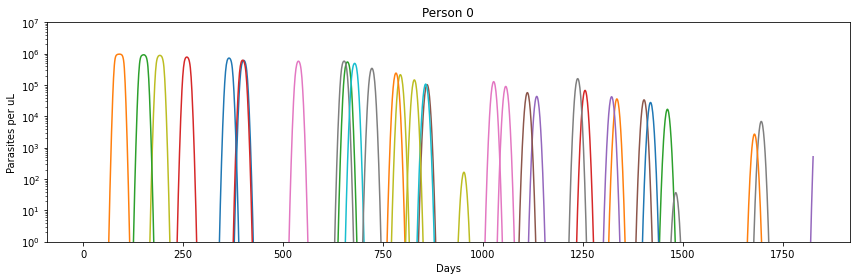

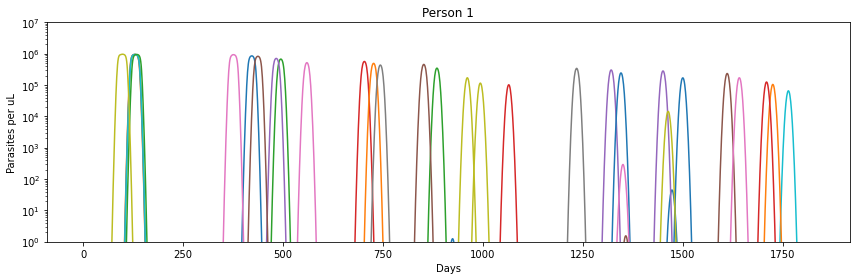

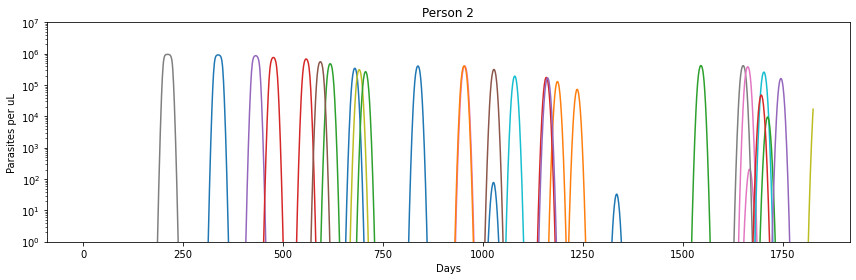

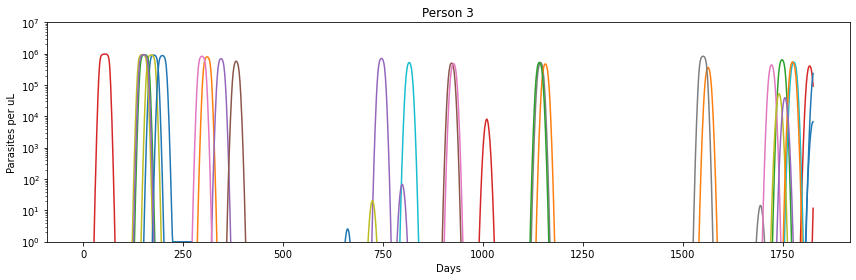

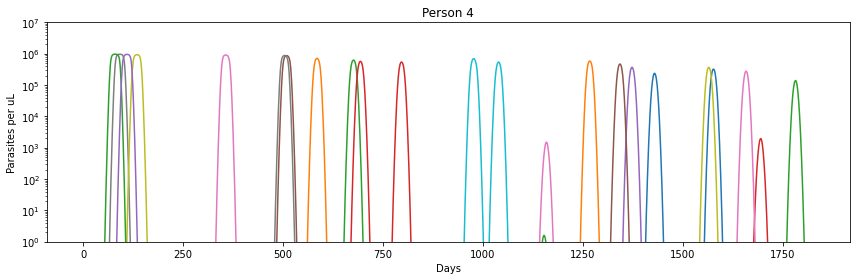

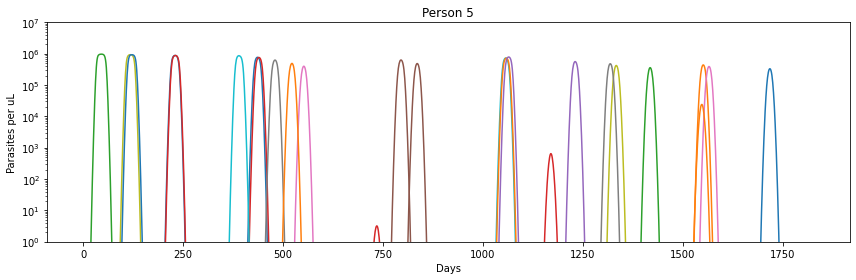

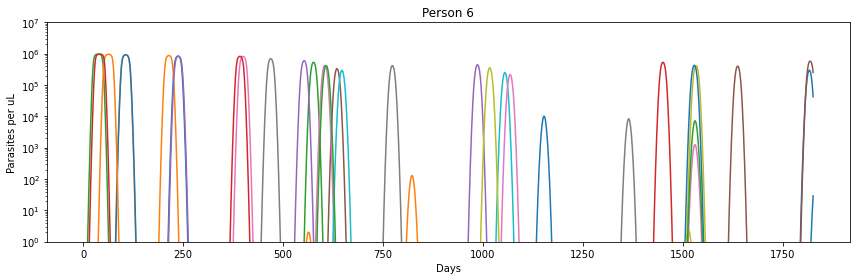

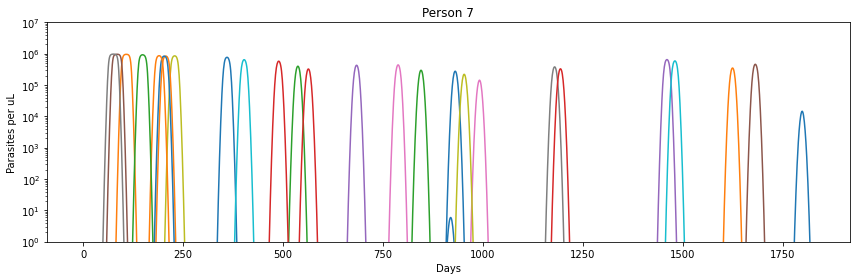

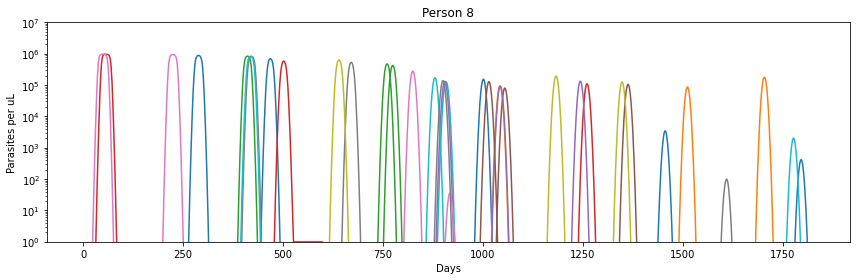

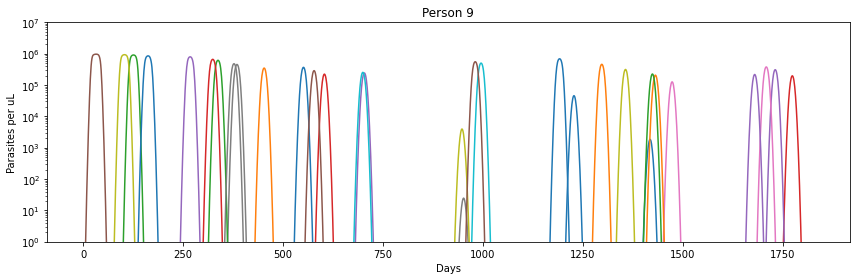

In [24]:
for i in np.arange(N):
    fig, ax = plt.subplots(figsize=(12,4))
    for strain in np.arange(n):
        pStrain = simulations[i,strain,:]
        if np.sum(pStrain) > 1:
            ax.plot(time, pStrain)
    ax.set_xlabel('Days')
    ax.set_ylabel('Parasites per uL')
    ax.set_title('Person ' + str(i))
    ax.set_yscale('log')
    ax.set_ylim([1,10000000])
    fig.tight_layout()
    #fig.savefig('figures/person' + str(i) + '_parasitemia_reducedImmuneWaning.png')
    #plt.close()
    

#### What is the average duration of infection?

In [26]:
def get_sim_stats(simulations, threshhold,n):
    '''
    Per person in simulation, returns 
    infection lengths (strain specific), 
    time between parasitemia, 
    # of infections (strain specific), &
    # of continuous periods of parasitemia.
    '''
    strain_immunity = []
    general_immunity = []
    infection_lengths = []
    between_infections = []
    n_infections = []
    g_infections = []
    N = len(simulations)
    for p in np.arange(N):
        infections = 0
        generic_infections = 0
        positive_times = np.where(simulations[p,:,:] > threshhold)[1]
        unique = np.unique(positive_times)
        for i in np.arange(len(unique)):
            if i==0:
                day1 = unique[i]
                generic_infections += 1
            else:
                time1 = unique[i]-day1
                if time1 > 1:
                    between_infections.append(time1-1)
                    generic_infections += 1
                day1 = unique[i]
        for strain in np.arange(n):
            infections_with_strain = 0
            locs = np.where(simulations[p,strain,:] < threshhold)[0]
            for v in np.arange(len(locs)):
                if v==0:
                    day = locs[v]
                else:
                    time = locs[v]-day
                    if time > 1:
                        infection_lengths.append(time)
                        infections_with_strain += 1
                        general_immunity.append(np.average(simulations[p,-1,day:locs[v]]))
                        strain_immunity.append(np.average(simulations[p,(strain+n),day:locs[v]]))
                    day = locs[v]
            infections += infections_with_strain
        n_infections.append(infections)
        g_infections.append(generic_infections)
    return infection_lengths, between_infections, n_infections, g_infections, strain_immunity, general_immunity

In [27]:
    infection_lengths = []
    between_infections = []
    n_infections = []
    g_infections = []
    threshhold=1
    for p in np.arange(50):
        infections = 0
        generic_infections = 0
        positive_times = np.where(simulations[p,:,:] > threshhold)[1]
        unique = np.unique(positive_times)
        for i in np.arange(len(unique)):
            if i==0:
                day1 = unique[i]
                generic_infections += 1
            else:
                time1 = unique[i]-day1
                if time1 > 1:
                    between_infections.append(time1-1)
                    generic_infections += 1
                day1 = unique[i]
        for strain in np.arange(n):
            infections_with_strain = 0
            locs = np.where(simulations[p,strain,:] < threshhold)[0]
            for v in np.arange(len(locs)):
                if v==0:
                    day = locs[v]
                else:
                    time = locs[v]-day
                    if time > 1:
                        infection_lengths.append(time)
                        infections_with_strain += 1
                    day = locs[v]
            infections += infections_with_strain
        n_infections.append(infections)
        g_infections.append(generic_infections)

IndexError: index 10 is out of bounds for axis 0 with size 10

In [32]:
np.average(infection_lengths)

45.26158940397351

In [28]:
np.std(infection_lengths)

8.016608264710301

In [29]:
np.average(between_infections)

17.0

In [30]:
np.average(n_infections)/6

5.033333333333333

In [31]:
np.average(g_infections)/6

0.18333333333333335

#### What is average number of infections per year & time between infections?

In [511]:
def plot_time_window(t1,t2,i):
    time = np.arange(t1+1,t2+1)
    i=0
    fig, ax = plt.subplots(figsize=(12,4))
    for strain in np.arange(n):
        pStrain = simulations[i,strain,t1:t2]
        if np.sum(pStrain) > 1:
            ax.plot(time, pStrain)
    ax.set_xlabel('Days')
    ax.set_ylabel('Parasite concentration')
    ax.set_title('Person ' + str(i))
    #ax.set_yscale('log')
    return plt.show()

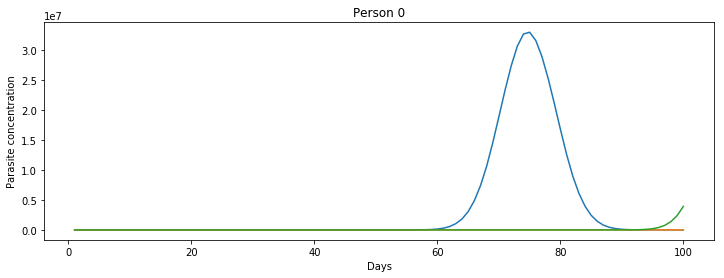

In [512]:
plot_time_window(0,100,0)

In [ ]:
plot_time_window(400,500,0)

In [ ]:
plot_time_window(1000,1100,0)

In [ ]:
plot_time_window(1500,1600,0)

In [ ]:
plot_time_window(2000,2100,0)

In [ ]:
bite_rate_length = []
length = []
between = []
bite_rate_between = []
bite_rate_person = []
infections = []
parasitemia = []
for k in np.arange(0.005, 0.11, 0.005):
    print(k)
    simulated = simulate_cohort(6,k,5,10)
    infection_lengths, between_infections, n_infections, n_parasitemia = get_sim_stats(simulated, 1, 10)
    
    tot_infections = len(infection_lengths)
    n_between = len(between_infections)
    n_persons = len(n_infections)
    
    bite_rate_length.extend([k]*tot_infections)
    bite_rate_between.extend([k]*n_between)
    bite_rate_person.extend([k]*n_persons)
    length.extend(infection_lengths)
    between.extend(between_infections)
    infections.extend(n_infections)
    parasitemia.extend(n_parasitemia)
    


    
    
    

In [ ]:
sims_length = pd.DataFrame()
sims_between = pd.DataFrame()
sims_person = pd.DataFrame()
sims_length["bite_rate"] = bite_rate_length
sims_length["infection_length"] = length
sims_between["bite_rate"] = bite_rate_between
sims_between["between_infections_length"] = between
sims_person["bite_rate"] = bite_rate_person
sims_person["infection (strain specific)"] = infections
sims_person["parasitemia detected"] = parasitemia
sims_person_long = pd.melt(sims_person, id_vars="bite_rate", value_vars=["infection (strain specific)","parasitemia detected"], var_name='type')
sims_person["bite_rate"] = bite_rate_person
sims_person["infection (strain specific)"] = infections
sims_person["parasitemia detected"] = parasitemia
sims_person_long = pd.melt(sims_person, id_vars="bite_rate", value_vars=["infection (strain specific)","parasitemia detected"], var_name='type')

In [ ]:
sims_person

In [ ]:
l = sns.relplot(x="bite_rate", y="infection_length", data=sims_length, kind="line")
(l.set_axis_labels("Average bites per day", "Length of infection")
  .tight_layout(w_pad=0))

In [ ]:
b = sns.relplot(x="bite_rate", y="between_infections_length", data=sims_between, alpha=0.5)
(b.set_axis_labels("Average bites per day", "Time between detectable parasitemia")
  .tight_layout(w_pad=0))

In [ ]:
g = sns.relplot(x="bite_rate", y="value", data=sims_person_long, hue="type", alpha=0.5)
    
(g.set_axis_labels("Average bites per day", "Number of episodes")
  .tight_layout(w_pad=0))
g.savefig("infections_bite_rate.pdf")

In [400]:
sim_highBiteRate = simulate_cohort(5,0.1,10,50)
sim_midBiteRate = simulate_cohort(5,0.05,10,50)
sim_lowBiteRate = simulate_cohort(5,0.01,10,50)

In [404]:
time = 5*365

ValueError: x and y must have same first dimension, but have shapes (1,) and (1825,)

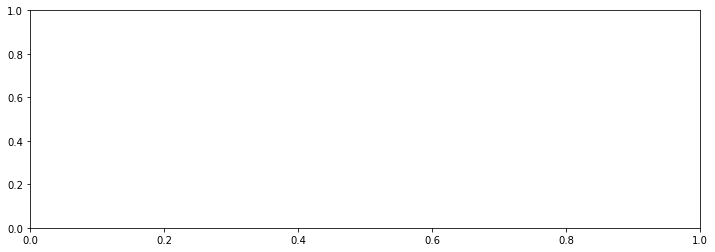

In [405]:
for i in np.arange(N):
    fig, ax = plt.subplots(figsize=(12,4))
    for strain in np.arange(n):
        iStrain = simulations[i,strain+n,:]
        if np.sum(iStrain) > 1:
            ax.plot(time, iStrain)
    ax.set_xlabel('Days')
    ax.set_ylabel('Strain specific immunity')
    ax.set_title('Person ' + str(i))

In [ ]:
for i in np.arange(N):
    fig, ax = plt.subplots(figsize=(12,4))
    for strain in np.arange(n):
        iStrain = sim_highBiteRate[i,strain+n,:]
        if np.sum(iStrain) > 1:
            ax.plot(time, iStrain)
    ax.set_xlabel('Days')
    ax.set_ylabel('Strain specific immunity')
    ax.set_title('Person ' + str(i))

In [406]:
lengths = []
bite_rate = []
strain_immunity = []
general_immunity = []
infection_lengths_high, between_infections_high, n_infections_high, n_parasitemia_high, strainI_high, gI_high = get_sim_stats(sim_highBiteRate, 5, 50)
lengths.extend(infection_lengths_high)
bite_rate.extend([0.1]*len(infection_lengths_high))
strain_immunity.extend(strainI_high)
general_immunity.extend(gI_high)

infection_lengths_mid, between_infections_mid, n_infections_mid, n_parasitemia_mid, strainI_mid, gI_mid = get_sim_stats(sim_midBiteRate, 5, 50)
lengths.extend(infection_lengths_mid)
bite_rate.extend([0.05]*len(infection_lengths_mid))
strain_immunity.extend(strainI_mid)
general_immunity.extend(gI_mid)

infection_lengths_low, between_infections_low, n_infections_low, n_parasitemia_low, strainI_low, gI_low = get_sim_stats(sim_lowBiteRate, 5, 50)
lengths.extend(infection_lengths_low)
bite_rate.extend([0.01]*len(infection_lengths_low))
strain_immunity.extend(strainI_low)
general_immunity.extend(gI_low)

df = pd.DataFrame()
df['bite_rate'] = bite_rate
df['infection_lengths'] = lengths
df['strain_immunity'] = strain_immunity
df['general_immunity'] = general_immunity

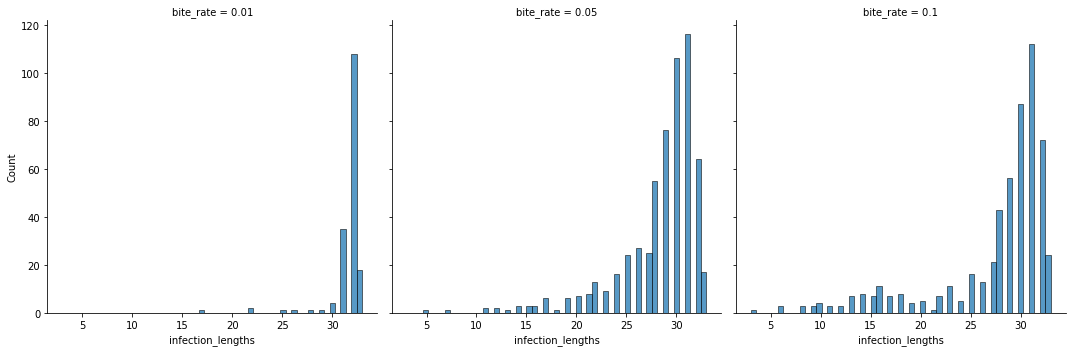

In [408]:
length = sns.displot(x="infection_lengths", data=df, col="bite_rate", kind="hist")
#length.savefig("Lengthdist_binary.png")

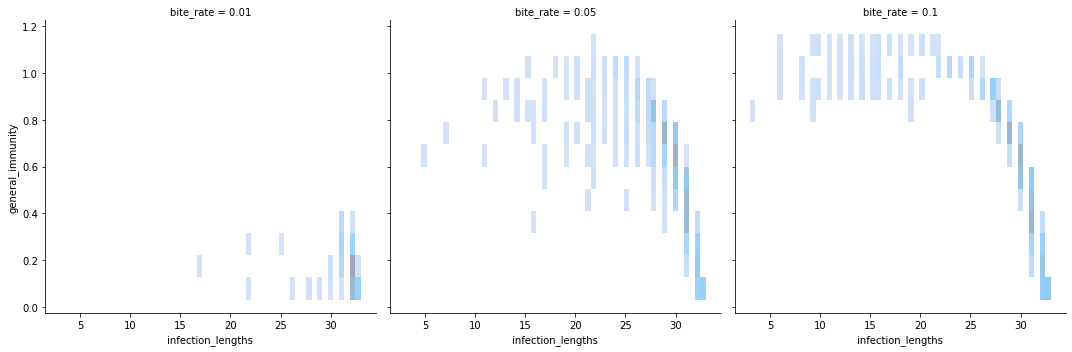

In [409]:
immunity = sns.displot(x='infection_lengths',y='general_immunity',data=df, col="bite_rate", alpha=0.5)
#immunity.savefig("infectionLengths_generalImmunity_binary.png")

In [410]:
dfLong = pd.melt(df, id_vars=["infection_lengths", "bite_rate"], value_vars=["strain_immunity", "general_immunity"], var_name="type", value_name="immunity")

In [411]:
dfLong

,infection_lengths,bite_rate,type,immunity
0,30,0.10,strain_immunity,0.672452
1,24,0.10,strain_immunity,0.344576
2,17,0.10,strain_immunity,0.244513
3,31,0.10,strain_immunity,1.034550
4,30,0.10,strain_immunity,0.879175
...,...,...,...,...
2613,32,0.01,general_immunity,0.098299
2614,32,0.01,general_immunity,0.131931
2615,32,0.01,general_immunity,0.077737
2616,32,0.01,general_immunity,0.124633


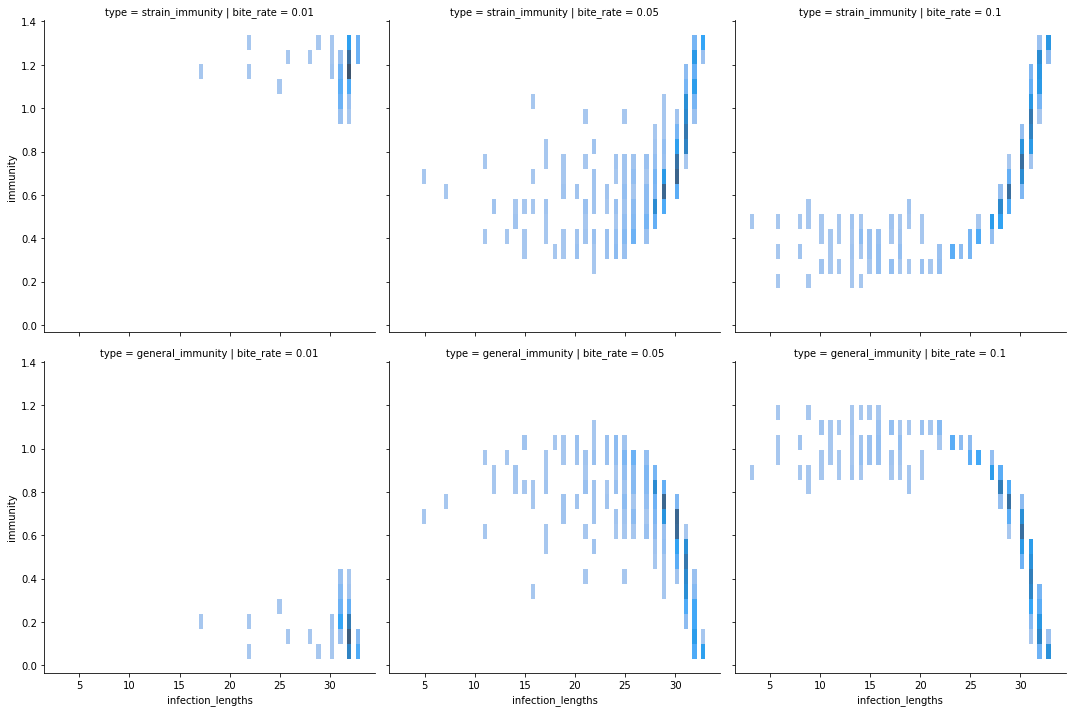

In [412]:
immunity = sns.displot(x="infection_lengths", y="immunity", row="type", col="bite_rate", data=dfLong)#, alpha=0.5)
#immunity.savefig("infectionLength_immunity.pdf")

In [413]:
general_immunity = np.average(sim_highBiteRate[:,-1,:], axis=0)
time = np.arange(len(general_immunity))
dfTime = pd.DataFrame()
dfTime['day'] = time
dfTime['general_immunity'] = general_immunity


In [ ]:
sns.relplot(x="general_immunity",y="day",data=dfTime,kind="line")